## Import Data and Libraries

In [1]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tkinter as tk
from PIL import Image
from tkinter import filedialog
import ipywidgets as widgets
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

In [2]:
# from collections import Counter
# # import scipy.spatial.distance as distance
# from sklearn.cluster import KMeans, MiniBatchKMeans  # Thêm MiniBatchKMeans
# from collections import Counter
from functools import lru_cache  # Thêm cache
from scipy.spatial.distance import euclidean

## Image preprocessing

In [3]:
# path = None
# path = 'D:/UTE/UTE_Nam_4_ki_2_DATN/Model&code_SAM/Picture_test/Image_test/abc.jpg'

# Select GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [4]:
# Hàm mở hộp thoại chọn file
def select_file():
    global path
    root = tk.Tk()
    root.withdraw()  # Ẩn cửa sổ chính của Tkinter
    root.attributes("-topmost", True)  # Hiển thị hộp thoại lên trên cùng
    file_path = filedialog.askopenfilename(filetypes=[("Image files", "*.jpg;*.png;*.jpeg;*.bmp;*.gif")])
    path = file_path  # Lưu đường dẫn vào biến source
    print(f"Đã chọn: {path}")


# Tạo nút bấm để mở hộp thoại
button = widgets.Button(description="Chọn ảnh")
button.on_click(lambda x: select_file())

display(button)

Button(description='Chọn ảnh', style=ButtonStyle())

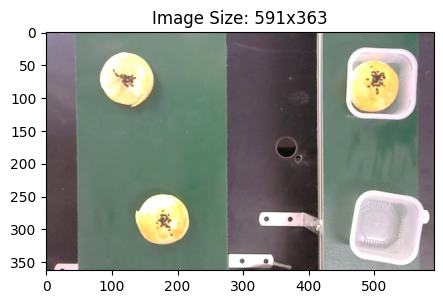

In [9]:
image = Image.open(path)
image = np.array(image)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Hiển thị hình ảnh
plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.axis('on')
plt.title(f"Image Size: {image.shape[1]}x{image.shape[0]}")
plt.show()

In [10]:
def crop_and_concatenate(image, rect1, rect2, axis='vertical', show=True):
    """
    Cắt hai hình chữ nhật từ ảnh và ghép chúng lại.
    
    Parameters:
    - image_path: Đường dẫn đến ảnh
    - rect1, rect2: Mỗi hình là np.array([[x1, y1], [x2, y2], [x3, y3], [x4, y4]])
    - axis: 'vertical' (mặc định) hoặc 'horizontal' để ghép ảnh
    - show: nếu True sẽ hiển thị ảnh ghép

    Returns:
    - image_concat: mảng ảnh sau khi ghép
    """
    # Đọc ảnh và chuyển sang array
    # image = Image.open(image_path)
    # image = np.array(image)
    
    def crop_rectangle(img, rect):
        x_min, x_max = rect[:, 0].min(), rect[:, 0].max()
        y_min, y_max = rect[:, 1].min(), rect[:, 1].max()
        return img[y_min:y_max, x_min:x_max]

    # Cắt hai vùng
    crop1 = crop_rectangle(image, rect1)
    crop2 = crop_rectangle(image, rect2)

    # Ghép ảnh
    if axis == 'horizontal':
        image_concat = np.concatenate((crop1, crop2), axis=1)
    else:  # vertical
        image_concat = np.concatenate((crop1, crop2), axis=0)

    # Hiển thị nếu cần
    if show:
        plt.figure(figsize=(6, 6))
        plt.imshow(image_concat)
        plt.axis('off')
        plt.title(f"Concatenated ({axis}) Image")
        plt.show()
    
    return image_concat

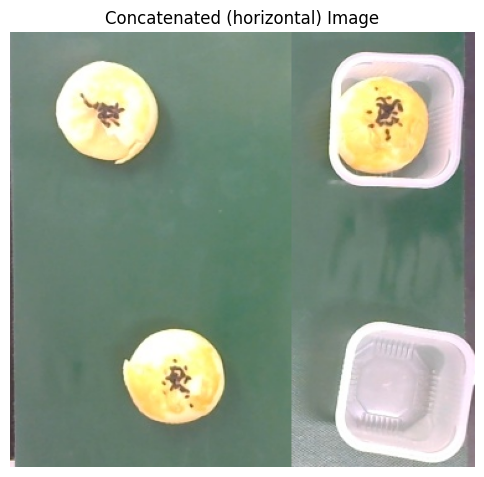

In [11]:
# crop1 =  np.array([[43, 5], [264, 5], [264, 473], [43, 473]])
# crop2 = np.array([[420, 5], [560, 5], [560, 473], [420, 473]])

# crop1 = np.array([[27, 8], [253, 8], [253, 471], [27, 471]])
# crop2 = np.array([[490, 8], [624, 8], [624, 471], [490, 471]])

# crop1 = np.array([[79, 4], [264, 4], [264, 477], [79, 477]])
# crop2 =   np.array([[443, 4], [574, 4], [574, 477], [443, 477]])

# crop1 =  np.array([[28, 5], [256, 5], [256, 474], [28, 474]])
# crop2 =  np.array([[458, 5], [615, 5], [615, 474], [458, 474]])

# crop1 = np.array([[25, 7], [255, 7], [255, 474], [25, 474]])
# crop2 = np.array([[458, 7], [615, 7], [615, 474], [458, 474]])

crop1 = np.array([[45, 8], [272, 8], [272, 359], [45, 359]])
crop2 =  np.array([[427, 8], [575, 8], [575, 359], [427, 359]])

image = crop_and_concatenate(image, crop1, crop2, axis='horizontal', show=True)


## Model Building 

In [12]:
def display_masked_images(image, masks, cols=3, figsize=None):
    """
    Hiển thị hình ảnh với các mask tô màu đỏ
    
    Parameters:
    -----------
    image : numpy.ndarray
        Ảnh gốc cần hiển thị
    masks : list 
        Danh sách các mask, mỗi mask là một dictionary có key 'segmentation'
    cols : int, optional
        Số cột trong lưới hiển thị, mặc định là 3
    figsize : tuple, optional
        Kích thước của figure (width, height), mặc định tính dựa trên số hàng và cột
    
    Returns:
    --------
    None
    """
    num_masks = len(masks)
    rows = (num_masks + cols - 1) // cols  # Tính số hàng cần thiết
    
    if figsize is None:
        figsize = (cols * 4, rows * 4)
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()  # Chuyển mảng 2D thành 1D để dễ duyệt
    
    for i, mask in enumerate(masks):
        masked_image = image.copy()
        mask_binary = mask['segmentation']  # Mask nhị phân (numpy array với 0/1)
        masked_image[mask_binary > 0] = [255, 0, 0]  # Tô màu đỏ
        
        axes[i].imshow(masked_image)
        axes[i].set_title(f"Mask {i + 1}")
        axes[i].axis("off")
    
    # Ẩn các ô dư thừa nếu có
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")
    
    plt.tight_layout()
    plt.show()

In [13]:
def compare_mask_areas(masks):
    """
    So sánh diện tích của các mask và in ra màn hình.

    Parameters:
    - masks: Danh sách dictionary chứa thông tin các mask được tạo bởi SAM2AutomaticMaskGenerator.
    
    Output:
    - In diện tích của từng mask (tính bằng số pixel).
    """
    if not masks:
        print("Không có mask nào được tạo.")
        return
    
    # Tính diện tích của từng mask
    mask_areas = [mask["area"] for mask in masks]
    
    # In diện tích từng mask
    print("So sánh diện tích các mask:")
    for i, area in enumerate(mask_areas):
        print(f"Mask {i+1}: Area = {area} pixels")

In [14]:
# model_cfg = "D:/UTE/UTE_Nam_4_ki_2_DATN/Model&code_SAM/Model_SAM2_JinsuaFeito/sam2.1_hiera_t.yaml"
# sam2_checkpoint = "D:/UTE/UTE_Nam_4_ki_2_DATN/Model&code_SAM/Model_SAM2_JinsuaFeito/sam2.1_hiera_tiny.pt"

model_cfg = "D:/UTE/UTE_Nam_4_ki_2_DATN/Model&code_SAM/Model_SAM2_JinsuaFeito/sam2.1_hiera_b+.yaml"
sam2_checkpoint = "D:/UTE/UTE_Nam_4_ki_2_DATN/Model&code_SAM/Model_SAM2_JinsuaFeito/sam2.1_hiera_base_plus.pt"

sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)

# mask_generator = SAM2AutomaticMaskGenerator(sam2)

In [15]:
mask_generator = SAM2AutomaticMaskGenerator(
    model=sam2,
    box_nms_thresh=0.7,            # Loại bỏ mask trùng
    multimask_output=True,         # Chỉ giữ một mask tốt nhất
    pred_iou_thresh=0.7,            # Chỉ giữ mask có chất lượng cao
    stability_score_thresh=0.7,    # Loại bỏ mask không ổn định
    crop_n_layers=0,                 # Không chia ảnh thành nhiều phần nhỏ
    # min_mask_area=50,           # Loại bỏ mask quá nhỏ
)

In [16]:
masks = mask_generator.generate(image)
num_masks = len(masks)
print(f"Số lượng mask trong ảnh: {num_masks}")

Số lượng mask trong ảnh: 13


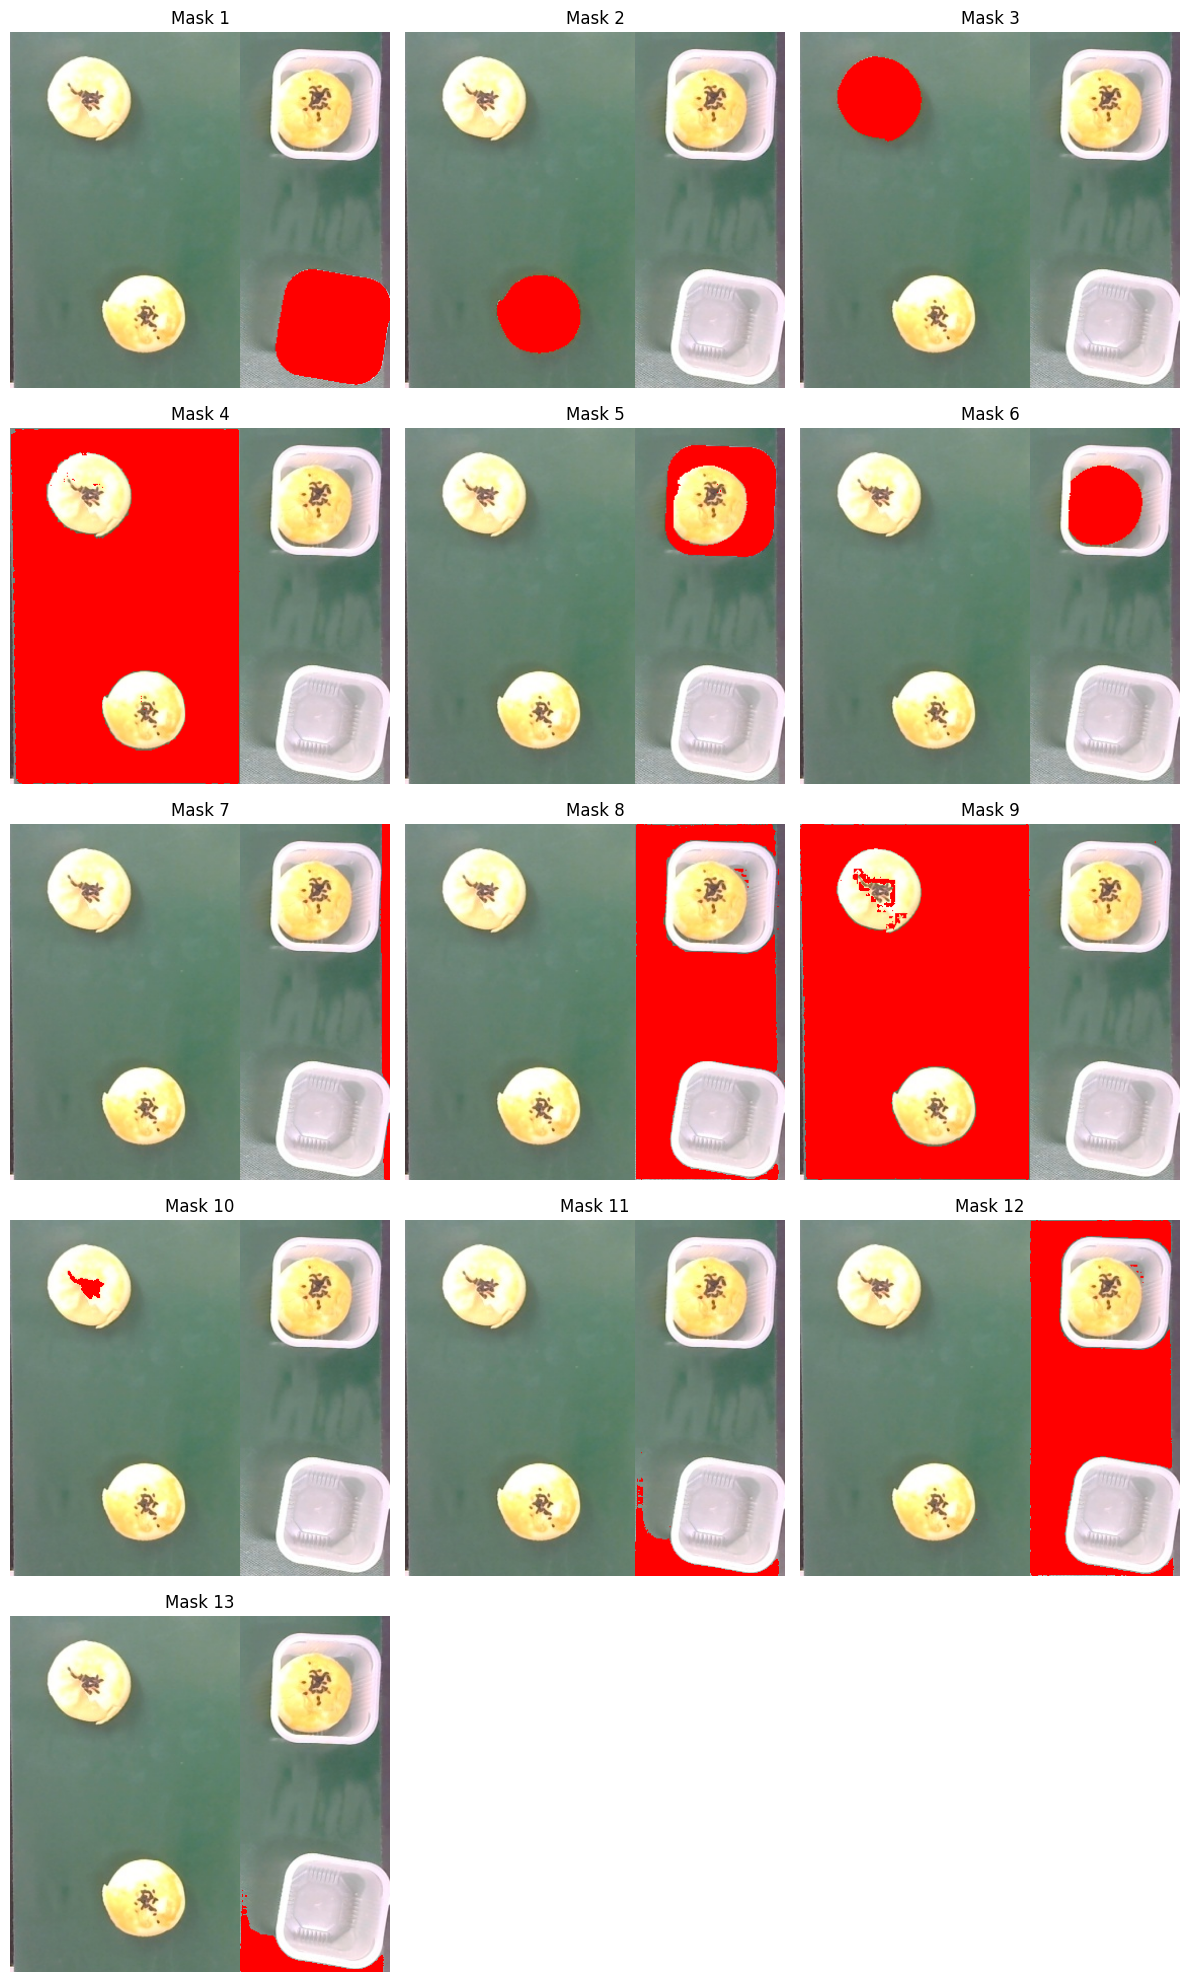

In [17]:
display_masked_images(image, masks)  # Sử dụng giá trị mặc định

In [18]:
compare_mask_areas(masks)

So sánh diện tích các mask:
Mask 1: Area = 10576 pixels
Mask 2: Area = 4913 pixels
Mask 3: Area = 5219 pixels
Mask 4: Area = 67215 pixels
Mask 5: Area = 6221 pixels
Mask 6: Area = 4699 pixels
Mask 7: Area = 2383 pixels
Mask 8: Area = 26599 pixels
Mask 9: Area = 67821 pixels
Mask 10: Area = 397 pixels
Mask 11: Area = 2720 pixels
Mask 12: Area = 26771 pixels
Mask 13: Area = 2517 pixels


In [25]:
def remove_background_mask(masks, remove_larger_than_threshold=False, remove_smallest=False, max_area_threshold=0, min_area_threshold=0):
    """
    Lọc danh sách các mask với tùy chọn loại bỏ mask lớn hơn ngưỡng và/hoặc các mask nhỏ hơn ngưỡng
    
    Args:
        masks: Danh sách các mask, mỗi mask là một dictionary
        remove_larger_than_threshold: Boolean chỉ định việc có loại bỏ mask lớn hơn ngưỡng hay không (mặc định là False)
        remove_smallest: Boolean chỉ định việc có loại bỏ các mask nhỏ hơn ngưỡng hay không (mặc định là False)
        area_threshold: Ngưỡng diện tích để xóa mask khi remove_larger_than_threshold=True (mặc định là 0)
        min_area_threshold: Ngưỡng diện tích tối thiểu khi remove_smallest=True (mặc định là 0)
        
    Returns:
        Danh sách các mask sau khi đã lọc theo điều kiện
    """
    if not masks:
        return []
    
    # Áp dụng các điều kiện lọc
    filtered_masks = []
    
    for mask in masks:
        # Kiểm tra điều kiện loại bỏ mask lớn hơn ngưỡng
        if remove_larger_than_threshold and mask['area'] > max_area_threshold:
            continue
            
        # Kiểm tra điều kiện loại bỏ mask nhỏ hơn ngưỡng
        if remove_smallest and mask['area'] < min_area_threshold:
            continue
            
        # Mask thỏa mãn tất cả điều kiện
        filtered_masks.append(mask)
    
    return filtered_masks

In [26]:
def filter_masks_by_squareness(masks, min_squareness_ratio=0.5):
    """
    Lọc bỏ các masks có tỉ lệ hình vuông thấp hơn ngưỡng đặt ra.
    
    Args:
        masks: Danh sách các mask, mỗi mask là dictionary có chứa bbox
        min_squareness_ratio: Ngưỡng tỉ lệ vuông tối thiểu (0.0 đến 1.0)
    
    Returns:
        Danh sách các mask đã được lọc, chỉ giữ lại mask có tỉ lệ vuông >= ngưỡng
    """
    result = []
    
    for mask in masks:
        # Lấy width và height từ bbox [x, y, width, height]
        width = mask['bbox'][2]
        height = mask['bbox'][3]
        
        # Tính tỉ lệ vuông (cạnh ngắn/cạnh dài)
        if width <= 0 or height <= 0:
            continue
            
        longer_side = max(width, height)
        shorter_side = min(width, height)
        squareness = shorter_side / longer_side
        
        # Chỉ giữ lại mask có tỉ lệ vuông >= ngưỡng
        if squareness >= min_squareness_ratio:
            result.append(mask)
    
    return result

In [27]:
def filter_masks_by_area_ratio(masks, min_area_ratio=0.3):
    """
    Lọc bỏ các masks có tỉ lệ diện tích (mask/bbox) thấp hơn ngưỡng đặt ra.
    
    Args:
        masks: Danh sách các mask, mỗi mask là dictionary có chứa 'area' và 'bbox'
        min_area_ratio: Ngưỡng tỉ lệ diện tích tối thiểu (0.0 đến 1.0)
    
    Returns:
        Danh sách các mask đã được lọc, chỉ giữ lại mask có tỉ lệ diện tích >= ngưỡng
    """
    result = []
    
    for mask in masks:
        # Lấy diện tích mask
        mask_area = mask['area']
        
        # Tính diện tích bbox
        bbox_width = mask['bbox'][2]
        bbox_height = mask['bbox'][3]
        bbox_area = bbox_width * bbox_height
        
        # Tính tỉ lệ diện tích mask/bbox
        if bbox_area <= 0:
            continue
            
        area_ratio = mask_area / bbox_area
        
        # Chỉ giữ lại mask có tỉ lệ diện tích >= ngưỡng
        if area_ratio >= min_area_ratio:
            result.append(mask)
    
    return result

In [28]:
def calculate_overlap_ratio(bbox1, bbox2):
    """
    Tính tỷ lệ phần giao của bbox nhỏ hơn so với diện tích của chính nó.
    
    Args:
        bbox1: Bounding box thứ nhất dạng [x, y, width, height]
        bbox2: Bounding box thứ hai dạng [x, y, width, height]
        
    Returns:
        Tỷ lệ diện tích phần giao / diện tích bbox nhỏ hơn
    """
    # Chuyển đổi từ [x, y, width, height] sang [x1, y1, x2, y2]
    x1_1, y1_1, w1, h1 = bbox1
    x2_1, y2_1 = x1_1 + w1, y1_1 + h1
    
    x1_2, y1_2, w2, h2 = bbox2
    x2_2, y2_2 = x1_2 + w2, y1_2 + h2
    
    # Tính toán diện tích của từng bbox
    area1 = w1 * h1
    area2 = w2 * h2
    
    # Tính toán tọa độ của vùng giao nhau
    x1_intersection = max(x1_1, x1_2)
    y1_intersection = max(y1_1, y1_2)
    x2_intersection = min(x2_1, x2_2)
    y2_intersection = min(y2_1, y2_2)
    
    # Kiểm tra xem hai bbox có giao nhau không
    if x2_intersection < x1_intersection or y2_intersection < y1_intersection:
        return 0.0
    
    # Tính diện tích phần giao nhau
    intersection_area = (x2_intersection - x1_intersection) * (y2_intersection - y1_intersection)
    
    # Lấy diện tích của bbox nhỏ hơn
    smaller_area = min(area1, area2)
    
    # Tính tỷ lệ phần giao so với bbox nhỏ hơn
    overlap_ratio = intersection_area / smaller_area if smaller_area > 0 else 0.0
    
    return overlap_ratio


# Hàm lọc mask dựa trên bounding box với tỷ lệ chồng lấp
def filter_masks_by_bbox_overlap(masks_data, overlap_threshold=0.9):
    """
    Lọc các mask dựa trên việc so sánh chồng lấp giữa các bounding box,
    loại bỏ bounding box nhỏ hơn khi có tỷ lệ chồng lấp vượt ngưỡng.
    
    Args:
        masks_data: List các dictionary chứa thông tin về mask
        overlap_threshold: Ngưỡng tỷ lệ chồng lấp (mặc định là 0.9 tương đương 90%)
        
    Returns:
        List các dictionary mask sau khi đã lọc
    """
    if len(masks_data) <= 1:
        return masks_data
    
    # Tạo bản sao để không ảnh hưởng đến dữ liệu gốc
    masks_to_process = masks_data.copy()
    
    # Tính diện tích cho tất cả bounding boxes
    for mask in masks_to_process:
        x, y, w, h = mask['bbox']
        mask['bbox_area'] = w * h
    
    # Sắp xếp masks theo diện tích bounding box từ lớn đến nhỏ
    sorted_masks = sorted(masks_to_process, key=lambda x: x['bbox_area'], reverse=True)
    
    masks_to_keep = []
    masks_to_remove = set()
    
    # So sánh từng cặp bounding box
    for i in range(len(sorted_masks)):
        if i in masks_to_remove:
            continue
            
        current_mask = sorted_masks[i]
        current_bbox = current_mask['bbox']
        
        for j in range(i+1, len(sorted_masks)):
            if j in masks_to_remove:
                continue
                
            compare_mask = sorted_masks[j]
            compare_bbox = compare_mask['bbox']
            
            # Tính tỷ lệ chồng lấp của bbox nhỏ hơn
            overlap_ratio = calculate_overlap_ratio(current_bbox, compare_bbox)
            
            # Nếu tỷ lệ chồng lấp vượt ngưỡng, loại bỏ bbox nhỏ hơn
            if overlap_ratio > overlap_threshold:
                # Vì sorted_masks đã sắp xếp theo diện tích giảm dần,
                # nên bbox tại j luôn nhỏ hơn hoặc bằng bbox tại i
                masks_to_remove.add(j)
    
    # Lấy ra các masks cần giữ lại
    for i in range(len(sorted_masks)):
        if i not in masks_to_remove:
            masks_to_keep.append(sorted_masks[i])
    
    return masks_to_keep


def fill_ring_masks(masks_data, image_shape, add_area=5000):
    """
    Điền đặc phần bên trong của các mask hình vành khuyên để tạo thành hình tròn đặc.
    Chỉ cập nhật area cho những mask thực sự được fill ring.
    
    Args:
        masks_data: List các dictionary chứa thông tin về mask
        image_shape: Tuple chứa kích thước của ảnh (height, width)
        
    Returns:
        List các dictionary mask sau khi đã điền đặc phần trong
    """
    height, width = image_shape
    filled_masks = []
    
    for mask_info in masks_data:
        mask = mask_info['segmentation']
        original_area = mask_info.get('area', np.sum(mask))
        
        # Tìm contours của mask
        contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Tạo mask mới để vẽ contour đã điền đặc
        filled_mask = np.zeros((height, width), dtype=np.uint8)
        
        # Vẽ tất cả các contours với điền đặc (-1)
        cv2.drawContours(filled_mask, contours, -1, 1, thickness=cv2.FILLED)
        
        # Tính diện tích mới sau khi fill
        new_area = np.sum(filled_mask)
        
        # Cập nhật mask trong mask_info
        new_mask_info = mask_info.copy()
        new_mask_info['segmentation'] = filled_mask
        
        # Chỉ cập nhật area nếu có sự thay đổi (tức là mask được fill ring)
        if new_area != original_area:
            new_mask_info['area'] = new_area + add_area  # Cộng thêm diện tích nếu cần
            new_mask_info['is_filled'] = True
        else:
            # Giữ nguyên area ban đầu nếu không có thay đổi
            new_mask_info['is_filled'] = False
        
        filled_masks.append(new_mask_info)
    
    return filled_masks


# Hàm xử lý tổng hợp
def process_masks(masks_data, image_shape, overlap_threshold=0.9, fill_ring=True, add_area=5000):
    """
    Xử lý tổng hợp: lọc bỏ masks nhỏ dựa trên overlap và điền đặc masks vành khuyên
    
    Args:
        masks_data: List các dictionary chứa thông tin về mask
        image_shape: Tuple chứa kích thước của ảnh (height, width)
        overlap_threshold: Ngưỡng tỷ lệ chồng lấp (mặc định là 0.9 tương đương 90%)
        
    Returns:
        List các dictionary mask sau khi đã lọc và điền đặc
    """
    # Bước 1: Lọc bỏ masks dựa trên overlap
    filtered_masks = filter_masks_by_bbox_overlap(masks_data, overlap_threshold)

    # Bước 2: Điền đặc các mask hình vành khuyên
    if fill_ring:
        filled_masks = fill_ring_masks(filtered_masks, image_shape)
    else:
        filled_masks = filtered_masks
    
    return filled_masks

In [29]:
# Loại bỏ mask của nền
masks = remove_background_mask(masks, remove_larger_than_threshold=True, max_area_threshold=12500,
                               remove_smallest=True, min_area_threshold=2000)                               

In [30]:
# Lọc bỏ mask có tỉ lệ vuông thấp hơn 0.5
masks = filter_masks_by_squareness(masks, min_squareness_ratio=0.6)  

In [31]:
# Lọc bỏ mask có tỉ lệ diện tích (mask/bbox) thấp hơn 0.3
masks = process_masks(masks, image.shape[:2], overlap_threshold=0.6, fill_ring=True, add_area=20000)

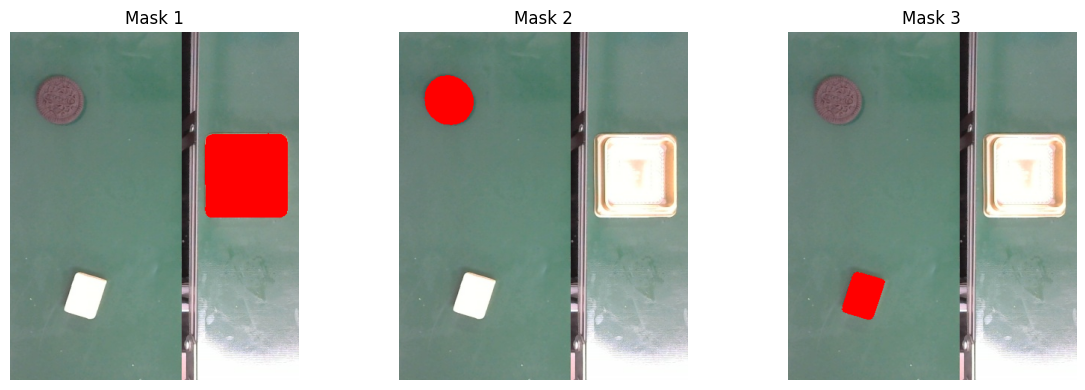

In [32]:
display_masked_images(image, masks)

In [33]:
def display_all_masks_on_image(image, masks, alpha=0.5):
    """
    Hiển thị tất cả các masks chồng lên ảnh gốc trong cùng một hình ảnh.

    Parameters:
    -----------
    image : numpy.ndarray
        Ảnh gốc cần hiển thị (dạng RGB).
    masks : list 
        Danh sách các mask, mỗi mask là một dictionary có key 'segmentation' chứa mảng nhị phân.
    alpha : float
        Mức độ trong suốt khi tô màu mask (giá trị từ 0 đến 1).

    Returns:
    --------
    None
    """
    # Sao chép ảnh gốc để không làm thay đổi ảnh ban đầu
    overlay_image = image.copy()

    for mask in masks:
        segmentation = mask['segmentation']
        # Tạo một layer màu đỏ (RGBA) với alpha
        red_layer = np.zeros_like(image, dtype=np.uint8)
        red_layer[..., 0] = 255  # Red channel
        # Áp dụng lớp đỏ lên vùng mask với alpha blending
        mask_indices = segmentation > 0
        overlay_image[mask_indices] = (
            (1 - alpha) * overlay_image[mask_indices] + alpha * red_layer[mask_indices]
        ).astype(np.uint8)

    plt.figure(figsize=(8, 8))
    plt.imshow(overlay_image)
    plt.axis('off')
    plt.title("Tất cả các masks trên một ảnh")
    plt.show()

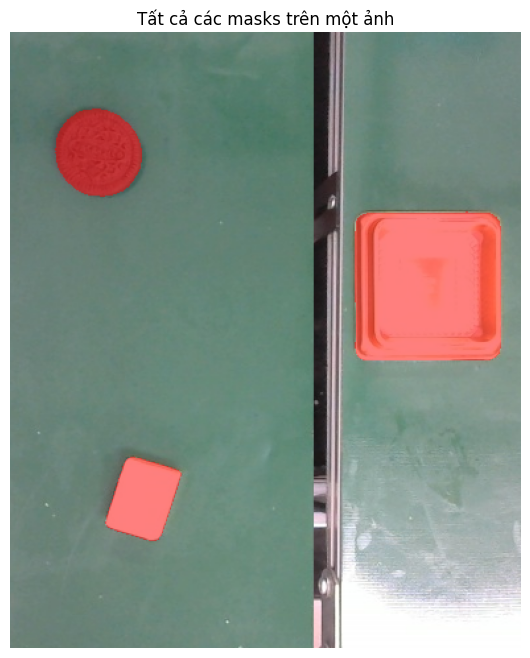

In [34]:
display_all_masks_on_image(image, masks, alpha=0.5)

In [35]:
compare_mask_areas(masks)

So sánh diện tích các mask:
Mask 1: Area = 12291 pixels
Mask 2: Area = 3433 pixels
Mask 3: Area = 2528 pixels


## Arrange the masks with color and area comparison

In [36]:
def rgb_to_lab(rgb):
    """
    Chuyển đổi màu từ RGB sang LAB color space
    LAB color space phản ánh tốt hơn sự nhận biết màu sắc của mắt người
    
    Parameters:
    -----------
    rgb : numpy.ndarray
        Giá trị RGB (0-255)
    
    Returns:
    --------
    numpy.ndarray
        Giá trị LAB
    """
    # Chuẩn hóa RGB về [0,1]
    rgb_normalized = rgb / 255.0
    
    # Chuyển đổi sang LAB
    # Tạo ảnh 1x1 pixel để sử dụng cv2.cvtColor
    rgb_pixel = np.uint8([[rgb]])
    lab_pixel = cv2.cvtColor(rgb_pixel, cv2.COLOR_RGB2LAB)
    
    return lab_pixel[0][0].astype(np.float32)

def rgb_to_hsv(rgb):
    """
    Chuyển đổi màu từ RGB sang HSV color space
    HSV tách biệt hue (màu sắc), saturation (độ bão hòa), value (độ sáng)
    
    Parameters:
    -----------
    rgb : numpy.ndarray
        Giá trị RGB (0-255)
    
    Returns:
    --------
    numpy.ndarray
        Giá trị HSV
    """
    rgb_pixel = np.uint8([[rgb]])
    hsv_pixel = cv2.cvtColor(rgb_pixel, cv2.COLOR_RGB2HSV)
    return hsv_pixel[0][0].astype(np.float32)

def delta_e_cie76(lab1, lab2):
    """
    Tính Delta E CIE 1976 - thước đo chuẩn cho sự khác biệt màu sắc
    
    Parameters:
    -----------
    lab1, lab2 : numpy.ndarray
        Giá trị màu trong LAB color space
    
    Returns:
    --------
    float
        Giá trị Delta E (càng nhỏ thì màu càng giống)
    """
    return np.sqrt(np.sum((lab1 - lab2) ** 2))

def hsv_distance_weighted(hsv1, hsv2):
    """
    Tính khoảng cách màu trong HSV với trọng số khác nhau cho H, S, V
    
    Parameters:
    -----------
    hsv1, hsv2 : numpy.ndarray
        Giá trị màu trong HSV color space
    
    Returns:
    --------
    float
        Khoảng cách có trọng số
    """
    h1, s1, v1 = hsv1
    h2, s2, v2 = hsv2
    
    # Tính khoảng cách cho Hue (circular distance)
    hue_diff = min(abs(h1 - h2), 180 - abs(h1 - h2))
    hue_distance = hue_diff / 180.0
    
    # Tính khoảng cách cho Saturation và Value
    sat_distance = abs(s1 - s2) / 255.0
    val_distance = abs(v1 - v2) / 255.0
    
    # Trọng số: Hue quan trọng nhất, sau đó đến Saturation, cuối cùng là Value
    weighted_distance = (0.5 * hue_distance + 
                        0.3 * sat_distance + 
                        0.2 * val_distance)
    
    return weighted_distance

def advanced_color_distance(color1, color2, method='lab'):
    """
    Tính khoảng cách màu sắc tiên tiến
    
    Parameters:
    -----------
    color1, color2 : numpy.ndarray
        Giá trị màu RGB (0-255)
    method : str
        Phương pháp so sánh ('lab', 'hsv', 'combined')
    
    Returns:
    --------
    float
        Khoảng cách màu sắc
    """
    if method == 'lab':
        lab1 = rgb_to_lab(color1)
        lab2 = rgb_to_lab(color2)
        return delta_e_cie76(lab1, lab2) / 100.0  # Chuẩn hóa về [0,1]
    
    elif method == 'hsv':
        hsv1 = rgb_to_hsv(color1)
        hsv2 = rgb_to_hsv(color2)
        return hsv_distance_weighted(hsv1, hsv2)
    
    elif method == 'combined':
        # Kết hợp cả LAB và HSV
        lab_distance = advanced_color_distance(color1, color2, 'lab')
        hsv_distance = advanced_color_distance(color1, color2, 'hsv')
        return 0.7 * lab_distance + 0.3 * hsv_distance
    
    else:
        raise ValueError("Method phải là 'lab', 'hsv', hoặc 'combined'")

def calculate_color_features_enhanced(image, mask):
    """
    Phiên bản cải tiến của calculate_color_features với nhiều thông tin màu sắc hơn
    
    Parameters:
    -----------
    image : numpy.ndarray
        Ảnh gốc (RGB format)
    mask : numpy.ndarray
        Mask nhị phân
    
    Returns:
    --------
    dict
        Dictionary chứa các đặc trưng màu sắc
    """
    # Lấy các pixel thuộc vật thể
    object_pixels = image[mask > 0]
    
    if len(object_pixels) == 0:
        return {
            'avg_color': np.zeros(3),
            'dominant_color': np.zeros(3),
            'color_std': np.zeros(3)
        }
    
    # Màu trung bình
    avg_color = np.mean(object_pixels, axis=0)
    
    # Màu chi phối (sử dụng K-means hoặc histogram)
    # Đơn giản hóa: lấy median
    dominant_color = np.median(object_pixels, axis=0)
    
    # Độ lệch chuẩn màu sắc (đo độ đồng nhất màu)
    color_std = np.std(object_pixels, axis=0)
    
    return {
        'avg_color': avg_color,
        'dominant_color': dominant_color,
        'color_std': color_std
    }

# Hàm cập nhật cho phần so sánh trong label_masks_from_examples
def compare_colors_enhanced(features1, features2, method='combined'):
    """
    So sánh đặc trưng màu sắc giữa hai vật thể
    
    Parameters:
    -----------
    features1, features2 : dict
        Dictionary chứa đặc trưng màu sắc
    method : str
        Phương pháp so sánh màu
    
    Returns:
    --------
    float
        Khoảng cách màu sắc (càng nhỏ càng giống)
    """
    # So sánh màu trung bình
    avg_distance = advanced_color_distance(
        features1['avg_color'], 
        features2['avg_color'], 
        method
    )
    
    # So sánh màu chi phối
    dom_distance = advanced_color_distance(
        features1['dominant_color'], 
        features2['dominant_color'], 
        method
    )
    
    # Kết hợp cả hai với trọng số
    combined_distance = 0.6 * avg_distance + 0.4 * dom_distance
    
    return combined_distance

In [37]:
def extract_mask_features(image, mask_dict):
    """
    Trích xuất các đặc trưng từ một mask
    
    Parameters:
    -----------
    image : numpy.ndarray
        Ảnh gốc (RGB format)
    mask_dict : dict
        Dictionary chứa thông tin về mask
    
    Returns:
    --------
    dict
        Dictionary chứa các đặc trưng của mask
    """
    # Lấy mask và thông tin
    mask = mask_dict['segmentation']
    area = mask_dict['area']
    
    # Tính đặc trưng màu sắc CẢI TIẾN
    color_features = calculate_color_features_enhanced(image, mask)
    
    return {
        'area': area,
        **color_features  # Unpack tất cả đặc trưng màu sắc
    }

def label_masks_from_examples(image, masks, labeled_indices, labels,
                              area_weight=0.4, color_weight=0.6):
    """
    Gán nhãn cho masks dựa trên các mask mẫu đã được gán nhãn (PHIÊN BẢN CẢI TIẾN)
    
    Parameters:
    -----------
    image : numpy.ndarray
        Ảnh gốc (RGB format)
    masks : list
        Danh sách các mask (dictionaries)
    labeled_indices : list
        Chỉ số của các mask đã được gán nhãn làm mẫu
    labels : dict
        Dictionary ánh xạ từ chỉ số mask đến nhãn tương ứng
    area_weight : float
        Trọng số cho đặc trưng diện tích
    color_weight : float
        Trọng số cho đặc trưng màu sắc
    
    Returns:
    --------
    dict
        Dictionary ánh xạ từ chỉ số mask đến nhãn được gán
    """
    # Tạo dictionary ánh xạ từ chỉ số mask đến nhãn
    mask_labels = {}
    for i, idx in enumerate(labeled_indices):
        if idx >= len(masks):
            raise ValueError(f"Chỉ số mask {idx} vượt quá số lượng mask có sẵn ({len(masks)})")
        if i not in labels:
            raise ValueError(f"Không tìm thấy nhãn cho vị trí {i} trong dictionary labels")
        mask_labels[idx] = labels[i]
    
    # Trích xuất đặc trưng cho các mask mẫu
    reference_features = {}
    for idx in labeled_indices:
        label = mask_labels[idx]
        features = extract_mask_features(image, masks[idx])
        
        if label not in reference_features:
            reference_features[label] = []
        reference_features[label].append(features)
    
    # Tính toán giá trị đặc trưng trung bình cho mỗi nhãn
    label_references = {}
    for label, features_list in reference_features.items():
        avg_area = np.mean([f['area'] for f in features_list])
        avg_color = np.mean([f['avg_color'] for f in features_list], axis=0)
        dominant_color = np.mean([f['dominant_color'] for f in features_list], axis=0)
        
        label_references[label] = {
            'area': avg_area,
            'avg_color': avg_color,
            'dominant_color': dominant_color
        }
    
    # Chuẩn hóa giá trị diện tích để có phạm vi từ 0 đến 1
    all_areas = [f['area'] for features in reference_features.values() for f in features]
    min_area, max_area = min(all_areas), max(all_areas)
    area_range = max_area - min_area
    
    if area_range > 0:
        for label, ref in label_references.items():
            ref['normalized_area'] = (ref['area'] - min_area) / area_range
    else:
        for label, ref in label_references.items():
            ref['normalized_area'] = 0.5
    
    # Gán nhãn cho tất cả masks
    result_labels = {}
    
    # Sao chép nhãn đã biết trước
    for idx in labeled_indices:
        result_labels[idx] = mask_labels[idx]
    
    # Gán nhãn cho các mask chưa biết
    for i, mask_dict in enumerate(masks):
        if i in labeled_indices:
            continue  # Bỏ qua mask đã được gán nhãn
        
        # Trích xuất đặc trưng của mask hiện tại
        features = extract_mask_features(image, mask_dict)
        
        # Chuẩn hóa diện tích
        if area_range > 0:
            normalized_area = (features['area'] - min_area) / area_range
        else:
            normalized_area = 0.5
        
        # So sánh với các nhãn đã biết
        min_distance = float('inf')
        best_label = None
        
        for label, ref in label_references.items():
            # So sánh diện tích
            area_distance = abs(normalized_area - ref['normalized_area'])
            
            # So sánh màu sắc CẢI TIẾN
            color_distance = compare_colors_enhanced(features, ref, method='combined')
            
            # Tính tổng khoảng cách có trọng số
            total_distance = area_weight * area_distance + color_weight * color_distance
            
            if total_distance < min_distance:
                min_distance = total_distance
                best_label = label
        
        result_labels[i] = best_label
    
    return result_labels

In [38]:
def compare_and_label_mask(reference_image, reference_masks, labeled_indices, base_labels,
                           new_image, new_masks, area_weight=0.4, color_weight=0.6):
    """
    So sánh và gán nhãn cho các mask trong ảnh mới dựa trên các mẫu đã được gán nhãn từ ảnh tham chiếu
    
    Parameters:
    -----------
    reference_image : numpy.ndarray
        Ảnh tham chiếu gốc (RGB format)
    reference_masks : list
        Danh sách các mask của ảnh tham chiếu
    labeled_indices : list
        Chỉ số của các mask đã được gán nhãn làm mẫu
    base_labels : dict
        Dictionary ánh xạ từ vị trí trong labeled_indices đến nhãn tương ứng
    new_image : numpy.ndarray
        Ảnh mới cần gán nhãn (RGB format)
    new_masks : list
        Danh sách các mask của ảnh mới
    area_weight : float, optional
        Trọng số cho đặc trưng diện tích, mặc định là 0.4
    color_weight : float, optional
        Trọng số cho đặc trưng màu sắc, mặc định là 0.6
    
    Returns:
    --------
    dict
        Dictionary ánh xạ từ chỉ số mask đến nhãn được gán trong ảnh mới
    """
    # Tạo reference_labels từ labeled_indices và base_labels
    reference_labels = {}
    for i, idx in enumerate(labeled_indices):
        if i in base_labels:
            reference_labels[idx] = base_labels[i]
    
    # Trích xuất đặc trưng cho các mask mẫu từ ảnh tham chiếu
    reference_features = {}
    for idx, label in reference_labels.items():
        features = extract_mask_features(reference_image, reference_masks[idx])
        
        if label not in reference_features:
            reference_features[label] = []
        reference_features[label].append(features)
    
    # Tính toán giá trị đặc trưng trung bình cho mỗi nhãn
    label_references = {}
    for label, features_list in reference_features.items():
        avg_area = np.mean([f['area'] for f in features_list])
        avg_color = np.mean([f['avg_color'] for f in features_list], axis=0)
        dominant_color = np.mean([f['dominant_color'] for f in features_list], axis=0)
        
        label_references[label] = {
            'area': avg_area,
            'avg_color': avg_color,
            'dominant_color': dominant_color
        }
    
    # Chuẩn hóa giá trị diện tích để có phạm vi từ 0 đến 1
    all_areas = [f['area'] for features in reference_features.values() for f in features]
    
    if len(all_areas) == 0:
        raise ValueError("Không có mask mẫu nào để tham chiếu")
    
    min_area, max_area = min(all_areas), max(all_areas)
    area_range = max_area - min_area
    
    if area_range > 0:
        for label, ref in label_references.items():
            ref['normalized_area'] = (ref['area'] - min_area) / area_range
    else:
        for label, ref in label_references.items():
            ref['normalized_area'] = 0.5
    
    # Gán nhãn cho tất cả masks trong ảnh mới
    result_labels = {}
    
    # Trích xuất và gán nhãn cho từng mask trong ảnh mới
    for i, mask_dict in enumerate(new_masks):
        # Trích xuất đặc trưng của mask hiện tại
        features = extract_mask_features(new_image, mask_dict)
        
        # Chuẩn hóa diện tích
        if area_range > 0:
            normalized_area = (features['area'] - min_area) / area_range
        else:
            normalized_area = 0.5
        
        # So sánh với các nhãn đã biết
        min_distance = float('inf')
        best_label = None
        
        for label, ref in label_references.items():
            # So sánh diện tích
            area_distance = abs(normalized_area - ref['normalized_area'])
            
            # So sánh màu sắc CẢI TIẾN
            color_distance = compare_colors_enhanced(features, ref, method='combined')
            
            # Tính tổng khoảng cách có trọng số
            total_distance = area_weight * area_distance + color_weight * color_distance
            
            if total_distance < min_distance:
                min_distance = total_distance
                best_label = label
        
        result_labels[i] = best_label
    
    return result_labels

In [39]:
def visualize_labeled_masks(image, masks, labels_map):
    """
    Hiển thị kết quả gán nhãn cho masks
    
    Parameters:
    -----------
    image : numpy.ndarray
        Ảnh gốc (RGB format)
    masks : list
        Danh sách các mask, mỗi mask là một dictionary
    labels_map : dict
        Từ điển ánh xạ chỉ số mask với nhãn tương ứng
    """
    import colorsys
    
    # Tạo bản sao của ảnh để vẽ lên
    result_image = image.copy()
    
    # Tạo màu khác nhau cho mỗi nhãn
    unique_labels = set(labels_map.values())
    label_colors = {}
    
    for i, label in enumerate(unique_labels):
        # Tạo màu HSV với các sắc thái khác nhau, độ bão hòa và độ sáng cố định
        hue = i / max(1, len(unique_labels))
        rgb = colorsys.hsv_to_rgb(hue, 0.8, 0.8)
        # Chuyển sang định dạng RGB (0-255)
        label_colors[label] = (
            int(rgb[0] * 255),
            int(rgb[1] * 255), 
            int(rgb[2] * 255)
        )
    
    # Vẽ kontour và nhãn cho mỗi mask
    for i, mask_dict in enumerate(masks):
        if i not in labels_map:
            continue
            
        mask = mask_dict['segmentation']
        label = labels_map[i]
        color = label_colors[label]
        
        # Tìm kontour của mask
        mask_uint8 = mask.astype(np.uint8) * 255
        contours, _ = cv2.findContours(
            mask_uint8, 
            cv2.RETR_EXTERNAL, 
            cv2.CHAIN_APPROX_SIMPLE
        )
        
        # Vẽ kontour
        cv2.drawContours(result_image, contours, -1, color, 2)
        
        # Tìm vị trí để hiển thị nhãn
        x, y, w, h = mask_dict['bbox']
        cv2.putText(
            result_image, 
            str(label), 
            (int(x), int(y) - 10), 
            cv2.FONT_HERSHEY_SIMPLEX, 
            0.9, 
            color, 
            2
        )
    
    # Hiển thị kết quả
    plt.figure(figsize=(12, 10))
    plt.imshow(result_image)
    plt.title('Kết quả gán nhãn')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # In thông tin gán nhãn
    print("Kết quả gán nhãn:")
    for mask_idx, label in labels_map.items():
        print(f"- Mask #{mask_idx}: {label}")


In [40]:
print(f"Số lượng mask: {len(masks)}")
print("Các nhãn (keys) trong một mask:", masks[0].keys())

Số lượng mask: 3
Các nhãn (keys) trong một mask: dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box', 'bbox_area', 'is_filled'])


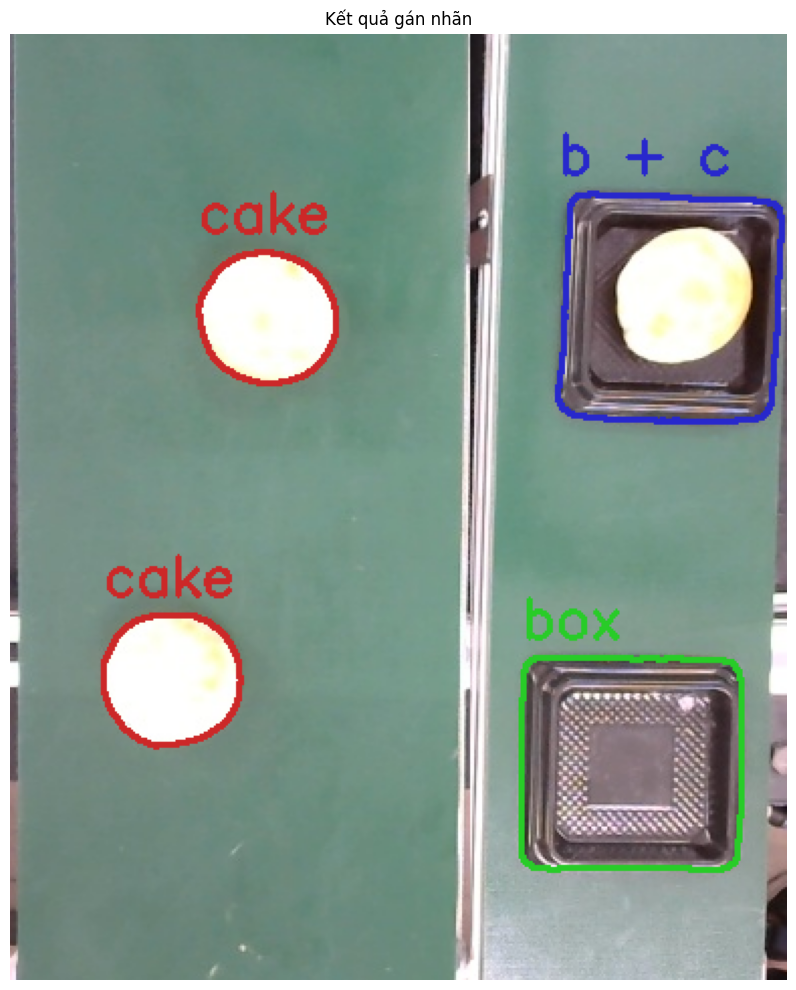

Kết quả gán nhãn:
- Mask #0: b + c
- Mask #1: box
- Mask #2: cake
- Mask #3: cake


In [38]:
# Chọn một số masks làm mẫu và gán nhãn cho chúng
labeled_indices = [0, 1, 2]  # Giả sử chọn mask 0 và 2 làm mẫu
base_labels = {
    0: "b + c",
    1: "box",
    2: "cake"
}

# Gán nhãn cho tất cả masks dựa trên mẫu đã chọn
all_labels = label_masks_from_examples(image, masks, labeled_indices, base_labels,
                                        area_weight=0.4, color_weight=0.6)

# Hiển thị kết quả
visualize_labeled_masks(image, masks, all_labels)

# Test the model with the test data

In [42]:
# path2 = 'Model&code_SAM/Picture_test/z6500493167611_2efbf7e23c42cd7721545f19cb4110cb.jpg'
# image2 = Image.open(path2)
# image2 = np.array(image2.convert("RGB"))
# # Resize về 720x720`````
# image2 = cv2.resize(image2, (200, 700), interpolation=cv2.INTER_AREA)
# # Lưu ảnh
# cv2.imwrite("resized_image.jpg", image2)

In [43]:
def compare_squareness_of_masks(masks):
    """
    In ra tỉ lệ hình vuông (squareness) của tất cả các mask.

    Args:
        masks: Danh sách các mask, mỗi mask là dictionary có chứa bbox [x, y, width, height]
    """
    for i, mask in enumerate(masks):
        width = mask['bbox'][2]
        height = mask['bbox'][3]

        if width <= 0 or height <= 0:
            print(f"Mask {i}: Invalid dimensions (width={width}, height={height})")
            continue

        longer_side = max(width, height)
        shorter_side = min(width, height)
        squareness = shorter_side / longer_side

        print(f"Mask {i}: Squareness ratio = {squareness:.4f}")


In [44]:
# print(path_2)

D:/UTE/UTE_Nam_4_ki_2_DATN/Thu_Thap_Data/Data/0530_114429_BY.jpg

In [45]:
# Hàm mở hộp thoại chọn file
def select_file():
    global path_2
    root = tk.Tk()
    root.withdraw()  # Ẩn cửa sổ chính của Tkinter
    root.attributes("-topmost", True)  # Hiển thị hộp thoại lên trên cùng
    file_path = filedialog.askopenfilename(filetypes=[("Image files", "*.jpg;*.png;*.jpeg;*.bmp;*.gif")])
    path_2 = file_path  # Lưu đường dẫn vào biến source
    print(f"Đã chọn: {path_2}")


# Tạo nút bấm để mở hộp thoại
button = widgets.Button(description="Chọn ảnh")
button.on_click(lambda x: select_file())

display(button)

Button(description='Chọn ảnh', style=ButtonStyle())

In [46]:
image_2 = Image.open(path_2)
image_2 = np.array(image_2)

print(path_2)

image_2 = crop_and_concatenate(image_2, crop1, crop2, axis='horizontal',
                               show=False
                               )

D:/UTE/UTE_Nam_4_ki_2_DATN/Thu_Thap_Data/Data_ver2_Banhpia/Data_tho/0610_115915_SP.jpg


In [47]:
# model_cfg = "D:/UTE/UTE_Nam_4_ki_2_DATN/Model&code_SAM/Model_SAM2_JinsuaFeito/sam2.1_hiera_b+.yaml"
# sam2_checkpoint = "D:/UTE/UTE_Nam_4_ki_2_DATN/Model&code_SAM/Model_SAM2_JinsuaFeito/sam2.1_hiera_base_plus.pt"

# mask_generator = SAM2AutomaticMaskGenerator(
#     model=sam2,
#     box_nms_thresh=0.7,            # Loại bỏ mask trùng
#     multimask_output=True,         # Chỉ giữ một mask tốt nhất
#     pred_iou_thresh=0.7,            # Chỉ giữ mask có chất lượng cao
#     stability_score_thresh=0.7,    # Loại bỏ mask không ổn định
#     crop_n_layers=0,                 # Không chia ảnh thành nhiều phần nhỏ
#     # min_mask_area=50,           # Loại bỏ mask quá nhỏ
# )

In [48]:
masks_2 = mask_generator.generate(image_2)

# display_masked_images(image_2, masks_2)

In [49]:
# Loại bỏ mask của nền
masks_2 = remove_background_mask(masks_2,
                                remove_larger_than_threshold=True,
                                max_area_threshold=13000,
                                remove_smallest=True,
                                min_area_threshold=4500) 

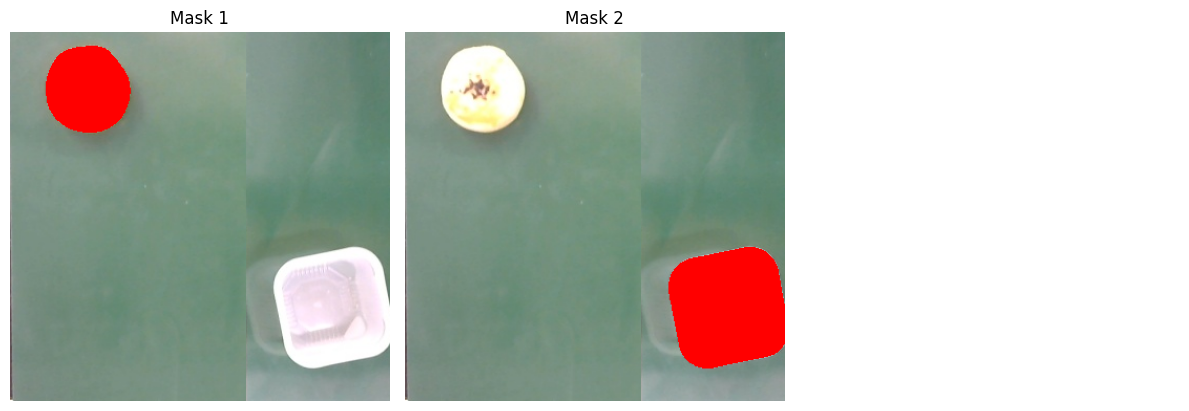

In [54]:
display_masked_images(image_2, masks_2)

In [39]:
compare_squareness_of_masks(masks_2)

Mask 0: Squareness ratio = 0.9872
Mask 1: Squareness ratio = 0.6222
Mask 2: Squareness ratio = 1.0000
Mask 3: Squareness ratio = 0.8390


In [47]:
compare_mask_areas(masks_2)

So sánh diện tích các mask:
Mask 1: Area = 76454 pixels
Mask 2: Area = 10336 pixels
Mask 3: Area = 10347 pixels
Mask 4: Area = 953 pixels
Mask 5: Area = 1070 pixels
Mask 6: Area = 78231 pixels
Mask 7: Area = 35920 pixels
Mask 8: Area = 10447 pixels
Mask 9: Area = 2709 pixels
Mask 10: Area = 10587 pixels


In [50]:
# Loại bỏ mask của nền
masks_2 = remove_background_mask(masks_2,
                                remove_larger_than_threshold=True,
                                max_area_threshold=13000,
                                remove_smallest=True,
                                min_area_threshold=4500)  

# Lọc bỏ mask có tỉ lệ vuông thấp hơn 0.5
masks_2 = filter_masks_by_squareness(masks_2, min_squareness_ratio=0.85) 

# Sử dụng phương pháp dựa trên bounding box
masks_2 = process_masks(masks_2, image_2.shape[:2],
                        overlap_threshold=0.6, fill_ring=True, add_area=5000)

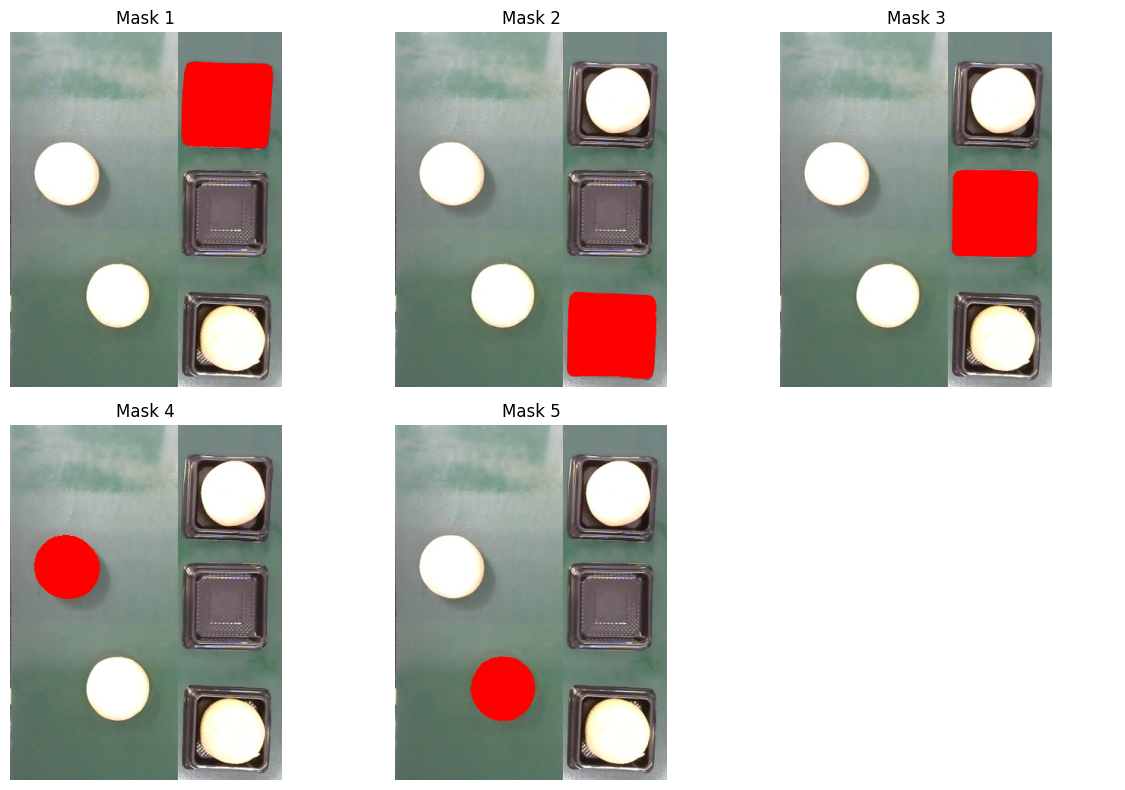

In [51]:
display_masked_images(image_2, masks_2)

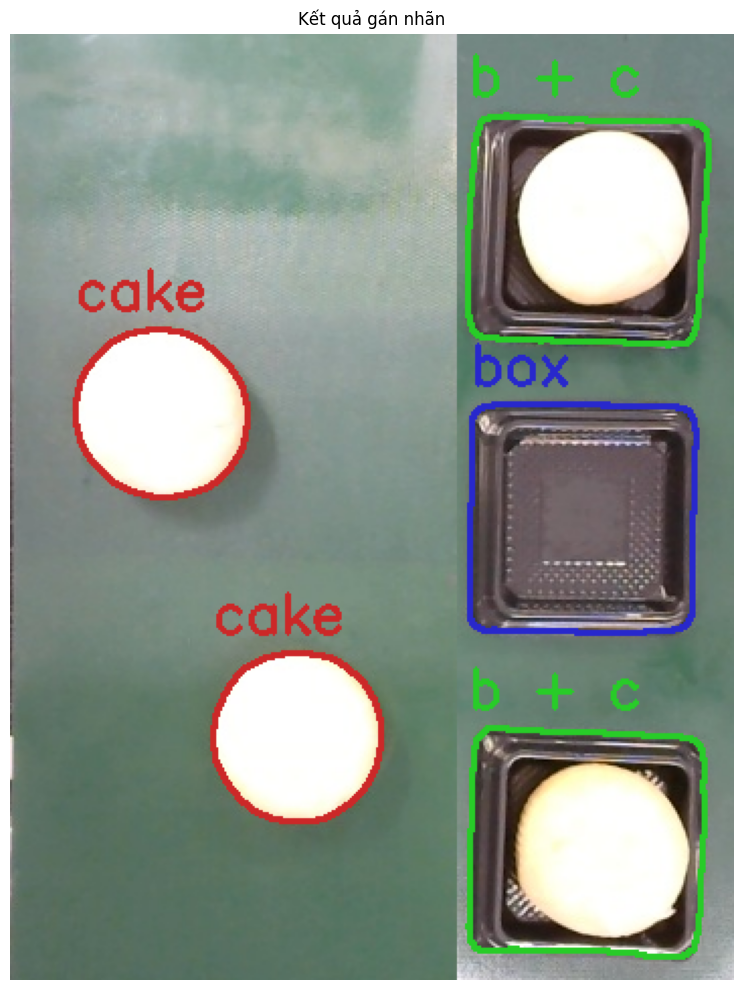

Kết quả gán nhãn:
- Mask #0: b + c
- Mask #1: b + c
- Mask #2: box
- Mask #3: cake
- Mask #4: cake


In [52]:
# # Gán nhãn cho ảnh mới
new_labels = compare_and_label_mask(image, masks, labeled_indices, base_labels,
                                    image_2, masks_2, area_weight=0.5, color_weight=0.5)

# 2. Hiển thị kết quả
visualize_labeled_masks(image_2, masks_2, new_labels)


In [ ]:
# Hàm mở hộp thoại chọn file
def select_file():
    global path
    root = tk.Tk()
    root.withdraw()  # Ẩn cửa sổ chính của Tkinter
    root.attributes("-topmost", True)  # Hiển thị hộp thoại lên trên cùng
    file_path = filedialog.askopenfilename(filetypes=[("Image files", "*.jpg;*.png;*.jpeg;*.bmp;*.gif")])
    path = file_path  # Lưu đường dẫn vào biến source
    print(f"Đã chọn: {path}")


# Tạo nút bấm để mở hộp thoại
button = widgets.Button(description="Chọn ảnh")
button.on_click(lambda x: select_file())

display(button)

In [ ]:
image = Image.open(path)
image = np.array(image)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image = cv2.resize(image, (230, 640), interpolation=cv2.INTER_AREA)

In [ ]:
# mask_generator = SAM2AutomaticMaskGenerator(
#     model=sam2,
#     box_nms_thresh=0.5,            # Loại bỏ mask trùng nhiều hơn
#     multimask_output=False,         # Chỉ giữ một mask tốt nhất
#     pred_iou_thresh=0.7,            # Chỉ giữ mask có chất lượng cao
#     stability_score_thresh=0.7,    # Loại bỏ mask không ổn định
#     crop_n_layers=0,                 # Không chia ảnh thành nhiều phần nhỏ
#     # min_mask_area=50,           # Loại bỏ mask quá nhỏ
# )

In [ ]:
masks = mask_generator.generate(image)
num_masks = len(masks)
print(f"Số lượng mask trong ảnh: {num_masks}")

In [ ]:
print("Các nhãn (keys) trong một mask:", masks[0].keys())

In [ ]:
display_masked_images(image, masks)  # Sử dụng giá trị mặc định

In [ ]:
# Loại bỏ mask của nền
masks = remove_background_mask(masks, remove_larger_than_threshold=True, max_area_threshold=25000,
                                remove_smallest=True, min_area_threshold=1000)                               

# Sử dụng phương pháp dựa trên bounding box
# masks_2 = process_masks(masks_2, image_2.shape[:2], overlap_threshold=0.8)


display_masked_images(image, masks)

In [ ]:
def calculate_mask_bbox_ratios(masks):
    """
    Tính tỉ lệ diện tích giữa masks và diện tích bounding box tương ứng.
    
    Args:
        masks: Danh sách các mask, mỗi mask là một dictionary có các key như 
               'segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 
               'stability_score', 'crop_box'
    
    Returns:
        Danh sách các dictionary chứa thông tin về mask và tỉ lệ diện tích:
        [
            {
                'mask_index': index của mask,
                'mask_area': diện tích của mask,
                'bbox_area': diện tích của bounding box,
                'area_ratio': tỉ lệ giữa diện tích mask và diện tích bounding box,
                'original_mask': tham chiếu đến mask gốc
            },
            ...
        ]
    """
    if not masks:
        return []
    
    results = []
    
    for idx, mask in enumerate(masks):
        # Lấy thông tin về mask
        mask_area = mask['area']
        
        # Lấy thông tin về bounding box
        # bbox thường có định dạng [x, y, width, height]
        bbox = mask['bbox']
        bbox_width = bbox[2]
        bbox_height = bbox[3]
        bbox_area = bbox_width * bbox_height
        
        # Tính tỉ lệ diện tích (mask area / bbox area)
        # Điều này cho biết mask chiếm bao nhiêu % diện tích của bounding box
        area_ratio = mask_area / bbox_area if bbox_area > 0 else 0
        
        # Tạo kết quả
        result = {
            'mask_index': idx + 1,
            'mask_area': mask_area,
            'bbox_area': bbox_area,
            'area_ratio': area_ratio,
            'original_mask': mask
        }
        
        results.append(result)
    
    return results


def print_mask_bbox_ratio_analysis(masks):
    """
    In phân tích chi tiết về tỉ lệ diện tích giữa masks và bounding box.
    
    Args:
        masks: Danh sách các mask
    """
    ratios = calculate_mask_bbox_ratios(masks)
    
    print(f"{'Index':<10}{'Mask Area':<15}{'BBox Area':<15}{'Ratio':<10}")
    print("-" * 50)
    
    for r in ratios:
        print(f"{r['mask_index']:<10}{r['mask_area']:<15.2f}{r['bbox_area']:<15.2f}{r['area_ratio']:<10.4f}")
    
    # Tính toán thống kê
    if ratios:
        avg_ratio = sum(r['area_ratio'] for r in ratios) / len(ratios)
        max_ratio = max(r['area_ratio'] for r in ratios)
        min_ratio = min(r['area_ratio'] for r in ratios)
        
        print("\nThống kê:")
        print(f"Tỉ lệ trung bình: {avg_ratio:.4f}")
        print(f"Tỉ lệ cao nhất: {max_ratio:.4f} (mask {ratios[max(range(len(ratios)), key=lambda i: ratios[i]['area_ratio'])]['mask_index']})")
        print(f"Tỉ lệ thấp nhất: {min_ratio:.4f} (mask {ratios[min(range(len(ratios)), key=lambda i: ratios[i]['area_ratio'])]['mask_index']})")

In [ ]:
print_mask_bbox_ratio_analysis(masks)

In [ ]:
masks_2 = filter_masks_by_area_ratio(masks_2, min_area_ratio=0.35)  # Giữ lại các mask có tỉ lệ diện tích >= 0.5

In [ ]:
display_masked_images(image_2, masks_2)  # Sử dụng giá trị mặc định

In [ ]:
# In phân tích tỉ lệ cho tất cả masks
print_mask_bbox_ratio_analysis(masks_2)

In [ ]:
def calculate_bbox_squareness(masks):
    """
    Tính tỉ lệ "vuông" của bounding box trong mỗi mask.
    Tỉ lệ vuông bằng 100% nếu bounding box là hình vuông hoàn hảo,
    và tiến dần về 0% khi tỉ lệ cạnh dài/cạnh ngắn tăng lên.
    
    Args:
        masks: Danh sách các mask, mỗi mask là một dictionary có chứa thông tin bbox
    
    Returns:
        Danh sách các dictionary chứa thông tin về mask và tỉ lệ vuông của bounding box:
        [
            {
                'mask_index': index của mask,
                'width': chiều rộng của bounding box,
                'height': chiều cao của bounding box,
                'squareness_ratio': tỉ lệ vuông của bounding box (0.0 đến 1.0),
                'squareness_percent': tỉ lệ vuông dưới dạng phần trăm (0% đến 100%),
                'aspect_ratio': tỉ lệ cạnh dài/cạnh ngắn,
                'original_mask': tham chiếu đến mask gốc
            },
            ...
        ]
    """
    if not masks:
        return []
    
    results = []
    
    for idx, mask in enumerate(masks):
        # Lấy thông tin về bounding box [x, y, width, height]
        bbox = mask['bbox']
        width = bbox[2]
        height = bbox[3]
        
        # Để tính tỉ lệ vuông, chúng ta đặt cạnh ngắn chia cho cạnh dài
        # Nếu là hình vuông hoàn hảo: cạnh ngắn = cạnh dài => tỉ lệ = 1.0 (100%)
        # Nếu một cạnh dài gấp đôi cạnh còn lại: tỉ lệ = 0.5 (50%)
        # Nếu một cạnh dài gấp nhiều lần cạnh còn lại: tỉ lệ tiến dần về 0.0 (0%)
        if width <= 0 or height <= 0:
            squareness_ratio = 0.0
            aspect_ratio = 0.0
        else:
            # Tìm cạnh dài và cạnh ngắn
            longer_side = max(width, height)
            shorter_side = min(width, height)
            
            # Tính tỉ lệ vuông và tỉ lệ khung hình
            squareness_ratio = shorter_side / longer_side if longer_side > 0 else 0.0
            aspect_ratio = longer_side / shorter_side if shorter_side > 0 else 0.0
        
        # Tạo kết quả
        result = {
            'mask_index': idx + 1,
            'width': width,
            'height': height,
            'squareness_ratio': squareness_ratio,
            'squareness_percent': squareness_ratio * 100,
            'aspect_ratio': aspect_ratio,
            'original_mask': mask
        }
        
        results.append(result)
    
    return results

def analyze_bbox_squareness(masks, sort_by='squareness_ratio', ascending=False, threshold=None):
    """
    Phân tích và so sánh tỉ lệ vuông của bounding box trong masks.
    
    Args:
        masks: Danh sách các mask
        sort_by: Tiêu chí sắp xếp ('squareness_ratio', 'aspect_ratio', 'width', 'height')
        ascending: Sắp xếp tăng dần (True) hoặc giảm dần (False)
        threshold: Ngưỡng tỉ lệ vuông để lọc kết quả (None để không lọc)
    
    Returns:
        Danh sách các mask đã được sắp xếp và tùy chọn lọc theo ngưỡng
    """
    # Tính toán tỉ lệ vuông cho tất cả masks
    squareness_results = calculate_bbox_squareness(masks)
    
    # Lọc theo ngưỡng nếu có
    if threshold is not None:
        squareness_results = [r for r in squareness_results if r['squareness_ratio'] >= threshold]
    
    # Sắp xếp theo tiêu chí
    squareness_results.sort(key=lambda x: x[sort_by], reverse=not ascending)
    
    return squareness_results

def find_most_square_masks(masks, top_n=3, min_squareness=0.5):
    """
    Tìm các mask có bounding box gần với hình vuông nhất.
    
    Args:
        masks: Danh sách các mask
        top_n: Số lượng mask vuông nhất để trả về
        min_squareness: Tỉ lệ vuông tối thiểu để xem xét (0.0 đến 1.0)
    
    Returns:
        Danh sách top n mask có bounding box vuông nhất
    """
    squareness_results = calculate_bbox_squareness(masks)
    
    # Lọc những mask có tỉ lệ vuông nhỏ hơn ngưỡng
    filtered_results = [r for r in squareness_results if r['squareness_ratio'] >= min_squareness]
    
    # Sắp xếp theo tỉ lệ vuông giảm dần
    sorted_results = sorted(filtered_results, key=lambda x: x['squareness_ratio'], reverse=True)
    
    # Lấy top n kết quả
    top_results = sorted_results[:top_n] if top_n > 0 else sorted_results
    
    # Trả về các mask gốc từ top kết quả
    return [r['original_mask'] for r in top_results]

def find_most_rectangular_masks(masks, top_n=3, max_squareness=0.5):
    """
    Tìm các mask có bounding box chữ nhật dài nhất (ít vuông nhất).
    
    Args:
        masks: Danh sách các mask
        top_n: Số lượng mask chữ nhật nhất để trả về
        max_squareness: Tỉ lệ vuông tối đa để xem xét (0.0 đến 1.0)
    
    Returns:
        Danh sách top n mask có bounding box chữ nhật nhất
    """
    squareness_results = calculate_bbox_squareness(masks)
    
    # Lọc những mask có tỉ lệ vuông lớn hơn ngưỡng
    filtered_results = [r for r in squareness_results if r['squareness_ratio'] <= max_squareness]
    
    # Sắp xếp theo tỉ lệ vuông tăng dần (ít vuông nhất lên đầu)
    sorted_results = sorted(filtered_results, key=lambda x: x['squareness_ratio'])
    
    # Lấy top n kết quả
    top_results = sorted_results[:top_n] if top_n > 0 else sorted_results
    
    # Trả về các mask gốc từ top kết quả
    return [r['original_mask'] for r in top_results]

def print_bbox_squareness_analysis(masks):
    """
    In phân tích chi tiết về tỉ lệ vuông của bounding box trong masks.
    
    Args:
        masks: Danh sách các mask
    """
    squareness_results = calculate_bbox_squareness(masks)
    
    print(f"{'Index':<10}{'Width':<10}{'Height':<10}{'Tỉ lệ vuông':<15}{'Tỉ lệ khung':<15}")
    print("-" * 60)
    
    for r in squareness_results:
        print(f"{r['mask_index']:<10}{r['width']:<10.1f}{r['height']:<10.1f}{r['squareness_percent']:<15.2f}%{r['aspect_ratio']:<15.2f}")
    
    # Tính toán thống kê
    if squareness_results:
        avg_squareness = sum(r['squareness_ratio'] for r in squareness_results) / len(squareness_results)
        max_squareness = max(r['squareness_ratio'] for r in squareness_results)
        min_squareness = min(r['squareness_ratio'] for r in squareness_results)
        
        print("\nThống kê:")
        print(f"Tỉ lệ vuông trung bình: {avg_squareness * 100:.2f}%")
        print(f"Tỉ lệ vuông cao nhất: {max_squareness * 100:.2f}% (mask {squareness_results[max(range(len(squareness_results)), key=lambda i: squareness_results[i]['squareness_ratio'])]['mask_index']})")
        print(f"Tỉ lệ vuông thấp nhất: {min_squareness * 100:.2f}% (mask {squareness_results[min(range(len(squareness_results)), key=lambda i: squareness_results[i]['squareness_ratio'])]['mask_index']})")

def get_combined_mask_analysis(masks):
    """
    Kết hợp phân tích tỉ lệ mask/bbox và tỉ lệ vuông của bbox.
    
    Args:
        masks: Danh sách các mask
    
    Returns:
        Danh sách các dictionary chứa thông tin kết hợp
    """
    if not masks:
        return []
    
    # Tính toán các tỉ lệ
    area_ratios = calculate_mask_bbox_ratios(masks)
    squareness_ratios = calculate_bbox_squareness(masks)
    
    # Kết hợp kết quả
    combined_results = []
    
    for i in range(len(masks)):
        area_ratio_info = next((ar for ar in area_ratios if ar['mask_index'] == i), None)
        squareness_info = next((sr for sr in squareness_ratios if sr['mask_index'] == i), None)
        
        if area_ratio_info and squareness_info:
            combined_result = {
                'mask_index': i,
                'mask_area': area_ratio_info['mask_area'],
                'bbox_area': area_ratio_info['bbox_area'],
                'area_ratio': area_ratio_info['area_ratio'],
                'width': squareness_info['width'],
                'height': squareness_info['height'],
                'squareness_ratio': squareness_info['squareness_ratio'],
                'aspect_ratio': squareness_info['aspect_ratio'],
                'original_mask': masks[i]
            }
            
            combined_results.append(combined_result)
    
    return combined_results

In [ ]:
# In phân tích tỉ lệ vuông cho tất cả masks
print_bbox_squareness_analysis(masks)

# Tìm top 3 mask có bounding box gần vuông nhất
square_masks = find_most_square_masks(masks, top_n=3, min_squareness=0.8)

# Tìm top 3 mask có bounding box là hình chữ nhật dài nhất
rectangular_masks = find_most_rectangular_masks(masks, top_n=3, max_squareness=0.3)

# Phân tích kết hợp để tìm masks vừa có tỉ lệ diện tích cao vừa có hình dạng vuông
combined_analysis = get_combined_mask_analysis(masks)
combined_analysis.sort(key=lambda x: (x['area_ratio'] + x['squareness_ratio']), reverse=True)

In [ ]:
# Giả sử `masks` là danh sách các mask đã được tạo bởi SAM2AutomaticMaskGenerator
for i, mask in enumerate(masks):
    print(f"Mask {i + 1}: Area = {mask['area']} pixels")

In [ ]:
display_masked_images(image, masks)  # Sử dụng giá trị mặc định

In [ ]:
# Lọc giữ lại masks có bounding box khá vuông (tỉ lệ >= 0.7)
square_masks = filter_masks_by_squareness(masks, min_squareness_ratio=0.9)

In [ ]:
display_masked_images(image, square_masks)  # Sử dụng giá trị mặc định